<a href="https://colab.research.google.com/github/nirajbhagat1/Marathi-Hate-Speech-Detection-ML-DL-Ensemble/blob/main/ml_dl_hate_speech_marathi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install numpy pandas scikit-learn tensorflow nltk


In [7]:
# #1. Data Preprocessing
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Download stopwords (this is still needed for other languages)
nltk.download('stopwords')

# Load dataset
data = pd.read_csv('/content/hate_bin_valid.xlsx - Sheet1.csv')
data.columns = ['text', 'label']  # Rename columns for convenience

# Load Marathi stopwords from a file
# Ensure that the path to 'marathi_stopwords.txt' is correct.
# If the file is in the same directory as your script, you can use just the filename.
# If it's in a different location, provide the full path.
try:
    with open('marathi_stopwords.txt', 'r', encoding='utf-8') as f:
        marathi_stopwords = [line.strip() for line in f]
except FileNotFoundError:
    print("Error: 'marathi_stopwords.txt' not found. Please check the file path.")
    marathi_stopwords = []  # Initialize as an empty list to avoid further errors

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = ' '.join([word for word in text.split() if word not in marathi_stopwords])  # Remove stopwords
    return text

# Apply preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Error: 'marathi_stopwords.txt' not found. Please check the file path.


In [8]:
#2. Feature Extraction
# TF-IDF Vectorizer for ML models
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [9]:
#3. Machine Learning Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train a Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Predictions and Evaluation for Logistic Regression
y_pred_lr = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Model")
print("Accuracy:", lr_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Model
Accuracy: 0.8493333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       390
           1       0.84      0.84      0.84       360

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750

Confusion Matrix:
 [[333  57]
 [ 56 304]]


In [10]:
#Part 4: Deep Learning Model (LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_length = max([len(x) for x in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

# Evaluate model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f'LSTM Model Accuracy: {lstm_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 512ms/step - accuracy: 0.4740 - loss: 0.6944 - val_accuracy: 0.4800 - val_loss: 0.6953
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.5003 - loss: 0.6939 - val_accuracy: 0.5200 - val_loss: 0.6929
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.5056 - loss: 0.6934 - val_accuracy: 0.4800 - val_loss: 0.6939
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 276ms/step - accuracy: 0.4981 - loss: 0.6940 - val_accuracy: 0.4800 - val_loss: 0.6933
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.5096 - loss: 0.6929 - val_accuracy: 0.5200 - val_loss: 0.6931
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5055 - loss: 0.6931
LSTM Model Accuracy: 0.5200


In [14]:
# Part 5: Ensemble Model Combining ML and DL

# Imports and other setup
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Assuming text preprocessing, feature extraction, and Logistic Regression training code above

# Define and train LSTM model
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))

# Wrapper class to use Keras model in sklearn pipeline
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Skip training here if the model is already trained
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        # This method is needed for 'soft' voting in VotingClassifier
        # Ensure the output is a 2D array of probabilities
        proba = self.model.predict(X)
        return np.column_stack([1 - proba, proba])  # Stack probabilities for both classes


# Initialize KerasClassifierWrapper with the trained LSTM model
lstm_wrapper = KerasClassifierWrapper(lstm_model)

# Create ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('lstm', lstm_wrapper)
], voting='soft')  # Use 'soft' voting to leverage probabilities

# Fit ensemble model with the Logistic Regression model only
# The LSTM model does not need to be retrained here
ensemble_model.fit(X_train_tfidf, y_train)

# Evaluate ensemble model
y_pred_ensemble = ensemble_model.predict(X_test_tfidf)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble Model")
print("Accuracy:", ensemble_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.4839 - loss: 0.6946 - val_accuracy: 0.4800 - val_loss: 0.6948
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.5067 - loss: 0.6930 - val_accuracy: 0.4800 - val_loss: 0.6942
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.4989 - loss: 0.6936 - val_accuracy: 0.4800 - val_loss: 0.6951
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.5017 - loss: 0.6937 - val_accuracy: 0.4800 - val_loss: 0.6943
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - accuracy: 0.4888 - loss: 0.6943 - val_accuracy: 0.4800 - val_loss: 0.6936
24/24 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step
Ensemble Model
Accuracy: 0.844
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       390
           1       0.83      0.84      0.84       360

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weig

In [18]:
def preprocess_and_predict(text):
    # Preprocess the input text
    processed_text = preprocess_text(text)

    # Transform the input for Logistic Regression (TF-IDF)
    input_tfidf = tfidf_vectorizer.transform([processed_text])

    # Predict with Logistic Regression
    lr_prediction = lr_model.predict(input_tfidf)
    lr_label = label_encoder.inverse_transform(lr_prediction)
    print(f"Logistic Regression Prediction: {lr_label[0]}")

    # Tokenize and pad the input for LSTM
    input_sequence = tokenizer.texts_to_sequences([processed_text])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Predict with LSTM
    lstm_prediction = (lstm_model.predict(input_padded) > 0.5).astype("int32")
    lstm_label = label_encoder.inverse_transform(lstm_prediction.flatten())
    print(f"LSTM Prediction: {lstm_label[0]}")

    # Predict with Ensemble model (if using ensemble)
    ensemble_prediction = ensemble_model.predict(input_tfidf)
    ensemble_label = label_encoder.inverse_transform(ensemble_prediction)
    print(f"Ensemble Model Prediction: {ensemble_label[0]}")


# Example test
input_text = "नंतर पुलवामा ची पण पाळेमुळे उखडून काढतील आणि फेक्या ला फासावर जावे लागेल"
print(input_text)
preprocess_and_predict(input_text)


नंतर पुलवामा ची पण पाळेमुळे उखडून काढतील आणि फेक्या ला फासावर जावे लागेल
Logistic Regression Prediction: NOT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
LSTM Prediction: NOT
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Ensemble Model Prediction: NOT


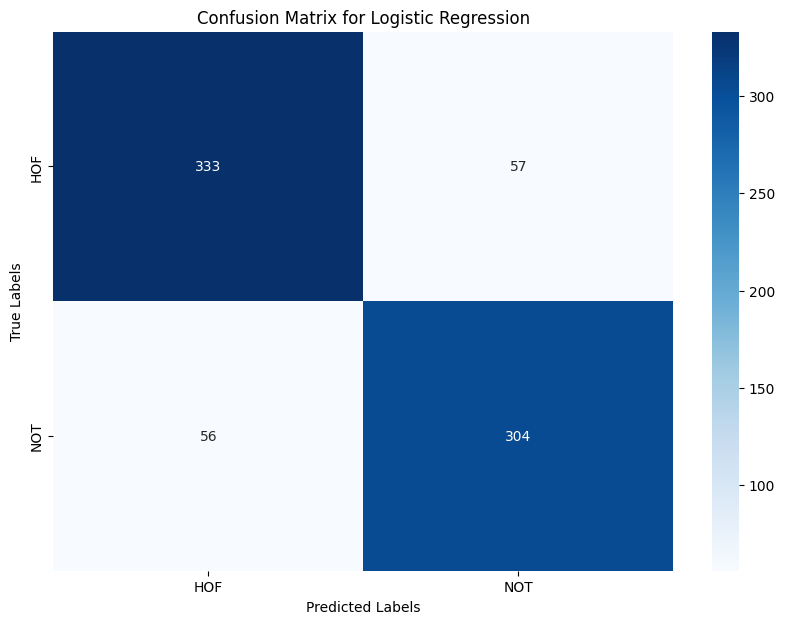

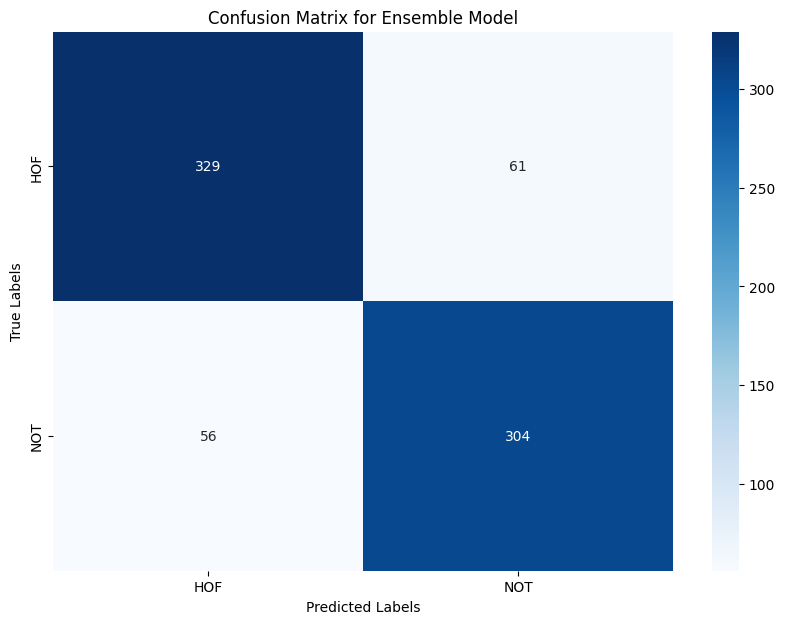

In [19]:
# 1. Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_lr (for Logistic Regression) are defined
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Assuming y_pred_ensemble (for Ensemble Model) is defined
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


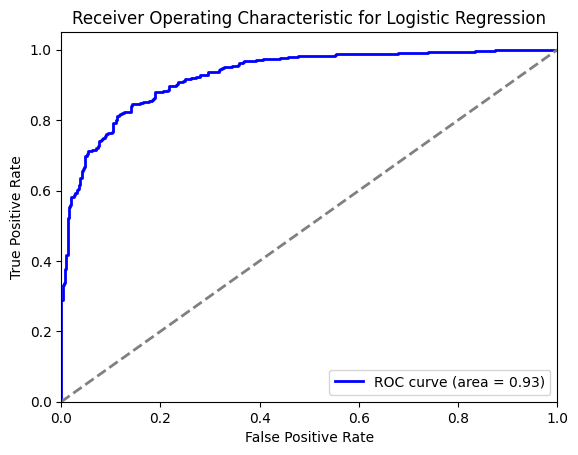

24/24 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step


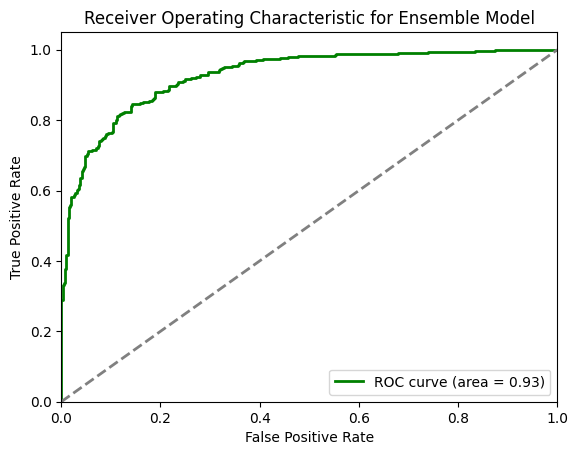

In [23]:
# 2. ROC Curve
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred_proba_lr (predicted probabilities for Logistic Regression) are defined
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# For Ensemble Model
# Assuming y_pred_proba_ensemble (predicted probabilities for Ensemble Model) are defined
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_tfidf)[:, 1]
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_proba_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure()
plt.plot(fpr_ensemble, tpr_ensemble, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_ensemble)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ensemble Model')
plt.legend(loc='lower right')
plt.show()


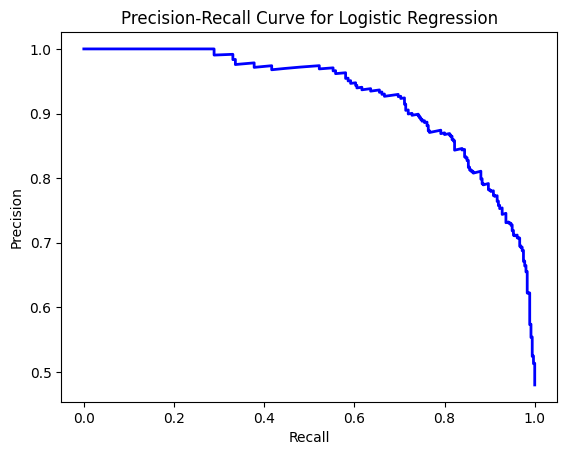

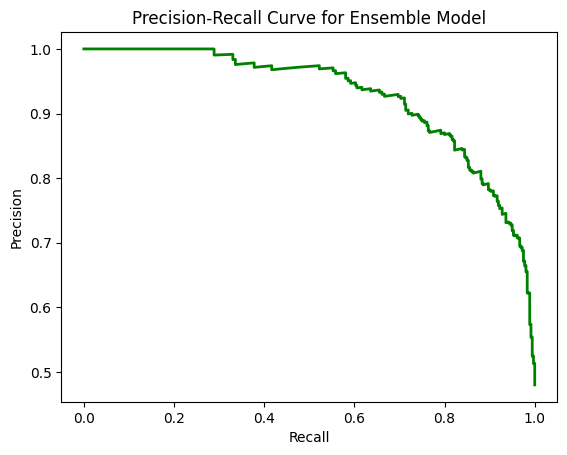

In [31]:
# 4. Precision-Recall Curve

from sklearn.metrics import precision_recall_curve

# Assuming y_test and y_pred_proba_lr (predicted probabilities for Logistic Regression) are defined
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure()
plt.plot(recall_lr, precision_lr, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.show()

# For Ensemble Model
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_proba_ensemble)

plt.figure()
plt.plot(recall_ensemble, precision_ensemble, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Ensemble Model')
plt.show()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 392ms/step - accuracy: 0.4835 - loss: 0.6938 - val_accuracy: 0.4800 - val_loss: 0.6955
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.5023 - loss: 0.6939 - val_accuracy: 0.4800 - val_loss: 0.6936
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.5156 - loss: 0.6932 - val_accuracy: 0.4800 - val_loss: 0.6936
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.4910 - loss: 0.6937 - val_accuracy: 0.4800 - val_loss: 0.6943
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.5109 - loss: 0.6927 - val_accuracy: 0.5200 - val_loss: 0.6924


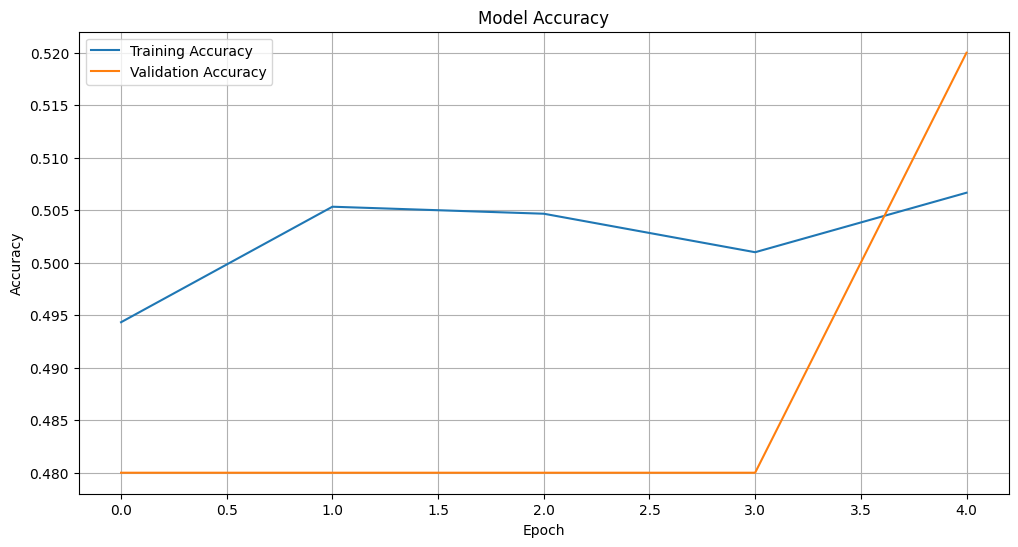

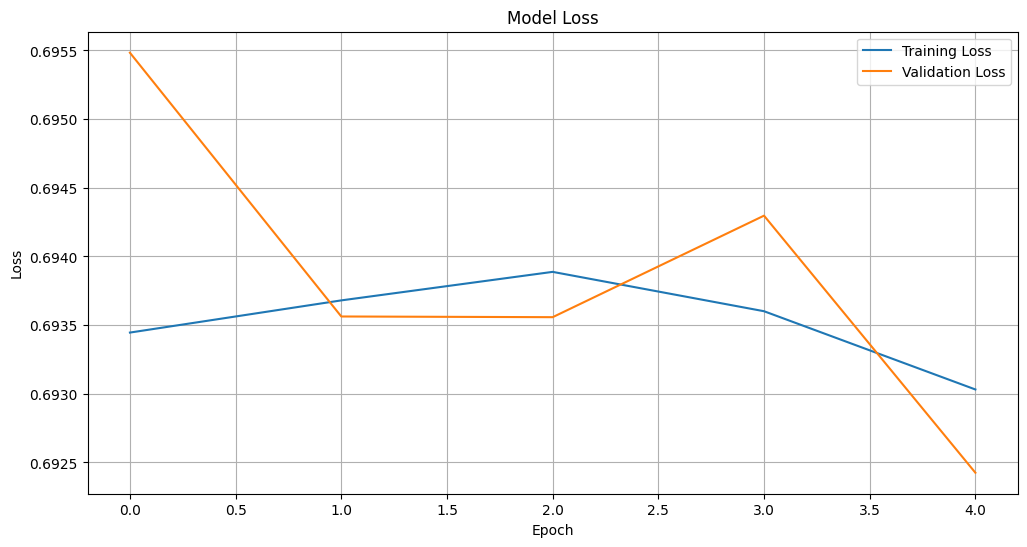

In [32]:
# Train the LSTM model and store the history
history = lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test))
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
